# 3W dataset's General Presentation

This is a general presentation of the 3W dataset, to the best of its authors' knowledge, the first realistic and public dataset with rare undesirable real events in oil wells that can be readily used as a benchmark dataset for development of machine learning techniques related to inherent difficulties of actual data.

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook presents the 3W dataset in a general way. For this, some tables, graphs, and statistics are presented.

# 2. Imports and Configurations

In [10]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import pickle

from river import stream, feature_extraction as fx, compose, stats, preprocessing, tree, metrics, evaluate
from river import linear_model, optim, drift, anomaly

import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import river
river.__version__

'0.11.1'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [3]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":

                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                        
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True):
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [6]:
if pathlib.Path('dset_river.pkl').exists():
  with open('dset_river.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_river.pkl', 'wb') as f:
      pickle.dump(dset, f)

In [11]:
flist0 = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[[0,1,2,3,4,5,6,7,8,101,102,103,104,105,106,107,108]]

train_df, test_df, val_df = dset.split(real=True, simul=True, drawn=True, test_size=0.1, val_size=0.2, sample_n=300)

Instances Train: 213  Test: 30  Validation: 54


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

More information about these variables can be obtained from the following publicly available documents:

* ***Option in Portuguese***: R.E.V. Vargas. Base de dados e benchmarks para prognóstico de anomalias em sistemas de elevação de petróleo. Universidade Federal do Espírito Santo. Doctoral thesis. 2019. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/doctoral_thesis_ricardo_vargas.pdf.
* ***Option in English***: B.G. Carvalho. Evaluating machine learning techniques for detection of flow instability events in offshore oil wells. Universidade Federal do Espírito Santo. Master's degree dissertation. 2021. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/master_degree_dissertation_bruno_carvalho.pdf.

In [45]:
dset.all

,label,path,nlines
0,0,..\dataset\0\WELL-00001_20170201020207.csv,17874
1,0,..\dataset\0\WELL-00001_20170201070114.csv,17927
2,0,..\dataset\0\WELL-00001_20170201120124.csv,17917
3,0,..\dataset\0\WELL-00001_20170201170311.csv,17810
4,0,..\dataset\0\WELL-00001_20170201220228.csv,17853
...,...,...,...
1976,8,..\dataset\8\SIMULATED_00077.csv,26999
1977,8,..\dataset\8\SIMULATED_00078.csv,26999
1978,8,..\dataset\8\SIMULATED_00079.csv,26999
1979,8,..\dataset\8\SIMULATED_00080.csv,26999


In [125]:
class CustomGen():
    
    def __init__(self, dset, flist, target, scaleb=False, out_time=False):
        self.dset = dset
        self.flist = flist
        self.target = target
        self.scaleb = scaleb
        self.out_time = out_time
        return
    
    def iter(self, max_n=None):
        n = 0
        for p in self.dset['path']:
            df = pd.read_csv(fpath, parse_dates=["timestamp"])

            if np.any(df[self.target].isna()):
                df[self.target] = df[self.target].fillna(method='ffill')
            df[self.target] = df[self.target].astype('int')

            if self.scaleb:
                np.seterr(divide='ignore', invalid='ignore')
                dfd = self.scale(df[self.flist]).to_dict(orient='records')
                np.seterr(divide='warn', invalid='warn')
            else:
                dfd = df[self.flist].to_dict(orient='records')
            for i, x in enumerate(dfd):
                if self.out_time:
                    yield df.iloc[i]['timestamp'], x, df.iloc[i][self.target]
                else:
                    yield x, df.iloc[i][self.target]
                n += 1
                if max_n is not None and n > max_n:
                    break

        return
    
    def scale(self, df):
        scale = StandardScaler()
        return pd.DataFrame(scale.fit_transform(df[self.flist]), columns=self.flist, index=df.index)

    def plot(self, ifile):
        
        ds = pd.read_csv(self.dset['path'][ifile], parse_dates=["timestamp"])
        fig, axs = plt.subplots(nrows=len(self.flist)+1, figsize=(10, 12), sharex=True)
        
        fig.suptitle(self.dset['path'][ifile])

        for i, vs in enumerate(self.flist):
            axs[i].plot(ds.timestamp[::60], ds[vs][::60])
            axs[i].set_ylabel(vs)
        
        id = np.argsort(ds[self.target])
        t = [ds.timestamp[i] for i in id][::60]
        y = [str(ds[self.target][i]) for i in id][::60]
        
        axs[i+1].scatter(t, y, marker='.')
        
        axs[i+1].set_ylabel(self.target)
        
        axs[i+1].set_xlabel('Date')
        
        for ax in axs:
            ax.grid(visible=True)

        plt.show()    


In [126]:
gen = CustomGen(dset.all, flist0, 'class', scaleb=True, out_time=True)
n = 0
for time, x, t in gen.iter():
    print(time, x, t)
    n += 1
    if n > 3:
        break

2014-10-06 16:01:21 {'P-PDG': -0.784691549171665, 'P-TPT': 0.651522861276284, 'T-TPT': 0.710449903071616, 'P-MON-CKP': nan, 'T-JUS-CKP': nan, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0
2014-10-06 16:01:22 {'P-PDG': -0.7845009237369222, 'P-TPT': 0.6515560460483424, 'T-TPT': 0.710449903071616, 'P-MON-CKP': nan, 'T-JUS-CKP': nan, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0
2014-10-06 16:01:23 {'P-PDG': -0.7843102983021792, 'P-TPT': 0.651593378916908, 'T-TPT': 0.7104469508473056, 'P-MON-CKP': nan, 'T-JUS-CKP': nan, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0
2014-10-06 16:01:24 {'P-PDG': -0.7841196728674363, 'P-TPT': 0.6516265636889664, 'T-TPT': 0.7104469508473056, 'P-MON-CKP': nan, 'T-JUS-CKP': nan, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0


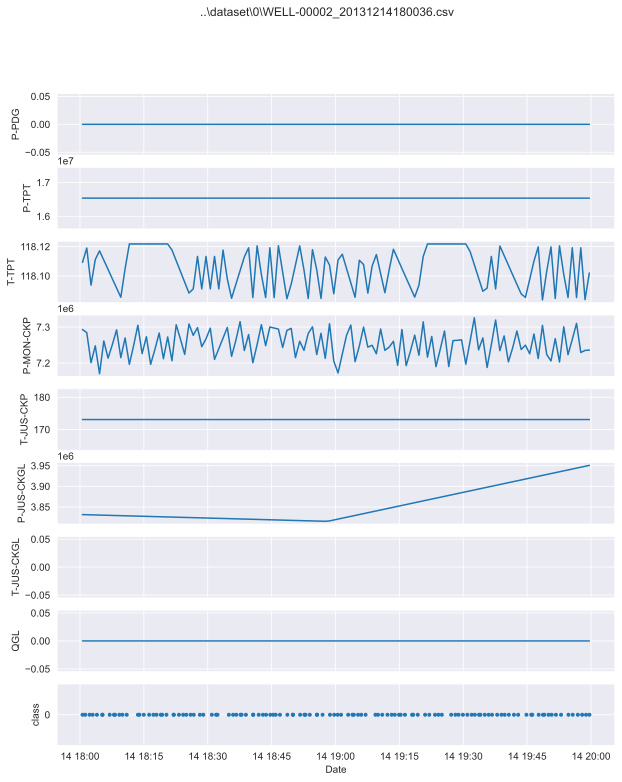

In [113]:
gen.plot(100)

In [ ]:
i = 0
for t, r in df[flist].iterrows():
    print(t, r.to_dict())
    i += 1
    if i > 5:
        break

In [141]:

scaler = preprocessing.StandardScaler()
#scaler = preprocessing.RobustScaler()

rmean = stats.RollingMean(window_size=900)
rSEM = stats.RollingSEM(ddof=1, window_size=900)
rMax = stats.RollingMax(window_size=900)
rMin = stats.RollingMin(window_size=900)
rtree = tree.HoeffdingTreeClassifier()
rlr = linear_model.LogisticRegression(optimizer=optim.SGD(.1))
metric = metrics.Accuracy()
#metric = metrics.ROCAUC()
#metric = metrics.ClassificationReport()

model = compose.Select(flist[0])
for f in flist:
    model += fx.Agg(on=f, by = None, how=rmean)
    model += fx.Agg(on=f, by = None, how=rSEM)
    model += fx.Agg(on=f, by = None, how=rMax)
    model += fx.Agg(on=f, by = None, how=rMin)
model |= compose.Discard(flist[0])
#model |= scaler
model |= rtree


In [142]:
gen = CustomGen(dset.drawn, flist0, 'class', scaleb=True, out_time=False)
evaluate.progressive_val_score(dataset=gen.iter(max_n=50000), model=model, metric=metric, delay=900, print_every=900)

[900] Accuracy: 0.00%
[1,800] Accuracy: 100.00%
[2,700] Accuracy: 100.00%
[3,600] Accuracy: 67.89%
[4,500] Accuracy: 73.75%
[5,400] Accuracy: 62.02%
[6,300] Accuracy: 68.15%
[7,200] Accuracy: 72.52%
[8,100] Accuracy: 63.78%
[9,000] Accuracy: 66.72%
[9,900] Accuracy: 61.03%
[10,800] Accuracy: 64.58%
[11,700] Accuracy: 67.02%
[12,600] Accuracy: 62.31%
[13,500] Accuracy: 63.95%
[14,400] Accuracy: 60.67%
[15,300] Accuracy: 63.13%
[16,200] Accuracy: 64.65%
[17,100] Accuracy: 61.67%
[18,000] Accuracy: 62.65%
[18,900] Accuracy: 60.51%
[19,800] Accuracy: 62.39%
[20,700] Accuracy: 63.37%
[21,600] Accuracy: 61.32%
[22,500] Accuracy: 61.91%
[23,400] Accuracy: 60.42%
[24,300] Accuracy: 61.94%
[25,200] Accuracy: 62.58%
[26,100] Accuracy: 61.10%
[27,000] Accuracy: 61.43%
[27,900] Accuracy: 60.36%
[28,800] Accuracy: 61.64%
[29,700] Accuracy: 62.03%
[30,600] Accuracy: 60.94%
[31,500] Accuracy: 61.08%
[32,400] Accuracy: 60.32%
[33,300] Accuracy: 61.42%
[34,200] Accuracy: 61.64%
[35,100] Accuracy: 60.82

Accuracy: 59.90%

In [ ]:
np.unique(df['class'], return_counts=True)

In [ ]:
model = model.clone()
evaluate.progressive_val_score(
    model = model,
    dataset = stream.iter_pandas(df_clean[flist], df_clean['class']),
    metric = metrics.Accuracy(),
    delay = 0, 
    print_every = 900)

## Drift test

In [ ]:
# Auxiliary function to plot the data
def plot_data(stream, sts, warnings=None, drifts=None):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)
    ax1.grid; ax2.grid
    ax1.set_ylabel('Stream'); ax2.set_ylabel('Stat')
    fig.suptitle('Drift test')
    ax1.plot(stream, label='Stream')
    ax2.plot(sts, label='stats')
    if drifts is not None:
        for drift_detected in drifts:
            ax2.axvline(stream.index[drift_detected], color='red', linewidth=0.5)
    if warnings is not None:
        for warning_detected in warnings:
            ax2.axvline(stream.index[warning_detected], color='green', linewidth=0.25)
    plt.show()

In [ ]:
df = tk.load_instance(real_instances[real_instances.label==3].iloc[0])
df_clean = df[flist+['class']].dropna()

#sem = stats.RollingSEM(ddof=1, window_size=30)
sem = stats.SEM()

f = 'P-TPT'
#drift_detector = drift.ADWIN(delta=0.002)
drift_detector = drift.DDM(min_num_instances=600)
warnings = []
drifts = []
sems = []

for i, val in enumerate(df_clean[f]):
    sems.append(sem.update(val).get())
    in_drift, in_warning = drift_detector.update(sems[-1])   # Data is processed one sample at a time
    if in_warning:
        # The drift detector indicates after each sample if there is a drift in the data
        #print(f'Change detected at index {i}')
        warnings.append(i)
#        drift_detector.reset()   # As a best practice, we reset the detector
    if in_drift:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}, {x}')
        drifts.append(i)
#        drift_detector.reset()   # As a best practice, we reset the detector

plot_data(df_clean[f], pd.Series(sems, index=df_clean.index), warnings=warnings, drifts=drifts)

In [ ]:
sems

## Anomaly detector

In [ ]:
df = tk.load_instance(real_instances[real_instances.label==2].iloc[0])
df_clean = df[flist+['class']].dropna()

f = 'T-TPT'

detector = anomaly.GaussianScorer(window_size=None, grace_period=300)

anomalies = []

for i, val in enumerate(df_clean[f]):
    anomalies.append(detector.score_one(None, val))
    detector = detector.learn_one(None, val)
anomalies = pd.Series(anomalies, index=df_clean.index)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 6), sharex=True)
ax1.grid
ax2.grid
ax3.grid
ax1.plot(df_clean[f], label='Stream', color='blue')
ax2.plot(anomalies, label='Anomalies prob', color='red')
ax2.axhline(0.95, color='green')
ax3.plot(df_clean['class'], label='class', color='black')

plt.tight_layout
plt.show()